<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Causal_Inference_Kevin_Hillstrom_Email_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference Kevin Hillstrom E-Mail Analytics

## info

* dataset: https://www.kaggle.com/datasets/bofulee/kevin-hillstrom-minethatdata-e-mailanalytics

## Install Necessary Libraries

In [1]:
# EconML is a library from Microsoft Research for econometrics and causal inference.
# Shap is used for explaining the output of machine learning models.

# Installing
!pip install econml
!pip install shap
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# The core Causal Forest model
from econml.dml import CausalForestDML

# Interpret
import shap

# better visualization
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
print("Libraries imported successfully.")


Libraries imported successfully.


## Load the Data

In [3]:
# load the dataset - CSV file
try:
    df = pd.read_csv('/content/drive/MyDrive/Causal_Inference_Kevin_Hillstrom_Email_Analytics/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
    print("Dataset loaded successfully. Shape:", df.shape)
    print("First 5 rows of the dataset:")
    display(df.head())
except FileNotFoundError:
    print("Error: 'Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv' not found.")
    print("Please make sure the file is in the correct directory.")


Dataset loaded successfully. Shape: (64000, 12)
First 5 rows of the dataset:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


## Data Cleaning and Feature Engineering

In [4]:
# Outcome (Y): We want to maximize customer spending.
Y = df['spend'].values

# Treatment (T): The 'segment' column tells us which marketing email a customer received.
treatment_map = {'No E-Mail': 0, 'Womens E-Mail': 1, 'Mens E-Mail': 2}
df['treatment'] = df['segment'].map(treatment_map)
T = df['treatment'].values
print("\nTreatment mapping:")
print(df['segment'].value_counts())



Treatment mapping:
segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64


## Feature Selection (Confounders)

In [5]:
# select features that could influence both the treatment assignment and the outcome.
# drop 'history_segment' as 'history' is the raw numerical version.
# drop 'conversion' and 'visit' as they are outcomes, not features.
features = ['recency', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
categorical_features = ['zip_code', 'channel']
numerical_features = ['recency', 'history', 'mens', 'womens', 'newbie']

print(f"\nCategorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")



Categorical Features: ['zip_code', 'channel']
Numerical Features: ['recency', 'history', 'mens', 'womens', 'newbie']


## Preprocessing Pipeline

In [6]:
# handle categorical and numerical features differently
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# confounder matrix W (and heterogeneity features X)
X = preprocessor.fit_transform(df[features])
W = X
feature_names_raw = numerical_features + \
                    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()


print(f"\nShape of Outcome (Y): {Y.shape}")
print(f"Shape of Treatment (T): {T.shape}")
print(f"Shape of Features (X/W): {X.shape}")
print(f"Number of features after transformation: {len(feature_names_raw)}")



Shape of Outcome (Y): (64000,)
Shape of Treatment (T): (64000,)
Shape of Features (X/W): (64000, 11)
Number of features after transformation: 11


## Train the Causal Forest Model

In [7]:
# estimating heterogeneous treatment effects in a multi-treatment setting
est = CausalForestDML(
    model_y='auto',
    model_t='auto',
    discrete_treatment=True,
    n_estimators=500, # A good balance of speed and performance
    min_samples_leaf=10,
    max_depth=10,
    random_state=123
)

est.fit(Y, T, X=X, W=W)
print("Model training completed.")


Model training completed.


## Visualize and Interpret Causal Effects

### Estimate the Causal Effect (Uplift) for Each Treatment

In [8]:
# Conditional Average Treatment Effect (CATE) for each customer and each treatment vs. control
# T0=0 is our control group ('No E-Mail')
# T1=1 is our first treatment ('Womens E-Mail')
# T1=2 is our second treatment ('Mens E-Mail')

uplift_womens = est.effect(X, T0=0, T1=1)
uplift_mens = est.effect(X, T0=0, T1=2)

# Add the uplift scores to our dataframe for analysis
df['uplift_womens'] = uplift_womens
df['uplift_mens'] = uplift_mens

print("\nUplift (CATE) calculated for each customer and treatment.")
print(df[['recency', 'history', 'spend', 'uplift_womens', 'uplift_mens']].head())



Uplift (CATE) calculated for each customer and treatment.
   recency  history  spend  uplift_womens  uplift_mens
0       10   142.44    0.0       0.063703     0.129433
1        6   329.08    0.0      -0.422596     0.260002
2        7   180.65    0.0       0.432702     0.160361
3        9   675.83    0.0       0.819311     0.862569
4        2    45.34    0.0       0.158756     5.477450


### Distribution of Uplift Scores

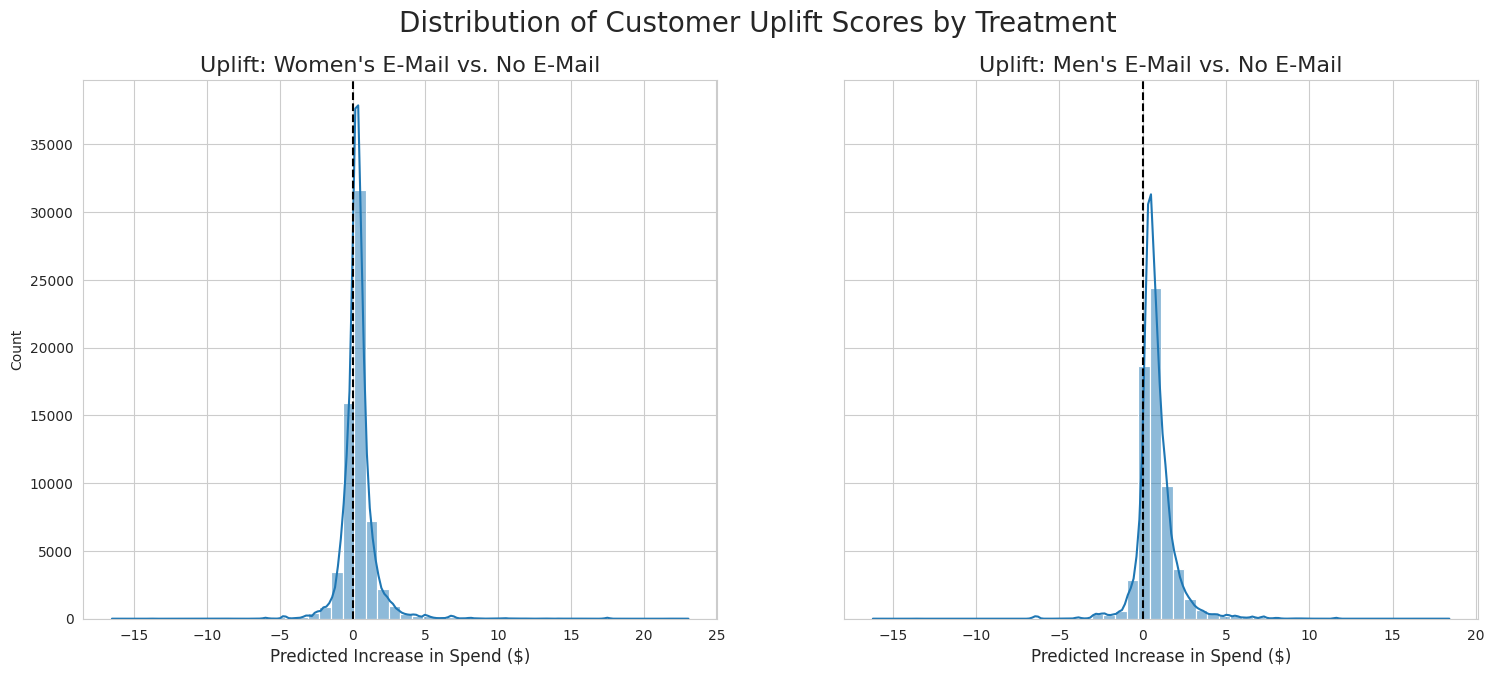

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.histplot(df['uplift_womens'], bins=50, kde=True, ax=ax1)
ax1.set_title("Uplift: Women's E-Mail vs. No E-Mail", fontsize=16)
ax1.set_xlabel("Predicted Increase in Spend ($)", fontsize=12)
ax1.axvline(0, color='black', linestyle='--')

sns.histplot(df['uplift_mens'], bins=50, kde=True, ax=ax2)
ax2.set_title("Uplift: Men's E-Mail vs. No E-Mail", fontsize=16)
ax2.set_xlabel("Predicted Increase in Spend ($)", fontsize=12)
ax2.axvline(0, color='black', linestyle='--')
plt.suptitle("Distribution of Customer Uplift Scores by Treatment", fontsize=20)
plt.show()


### SHAP Analysis to Explain Uplift (FAST & ROBUST VERSION)

* This tells us ***why*** some customers are more responsive to a specific campaign.



Creating a stratified sample for SHAP analysis (using 5% of data for speed and stability)...
Sampled data shape: (3200, 11)
Treatment counts in sample:
 1    1069
2    1066
0    1065
Name: count, dtype: int64

Running SHAP analysis on the stratified sample...


100%|===================| 6391/6400 [11:48<00:00]       


Plotting SHAP summary for Women's E-Mail...


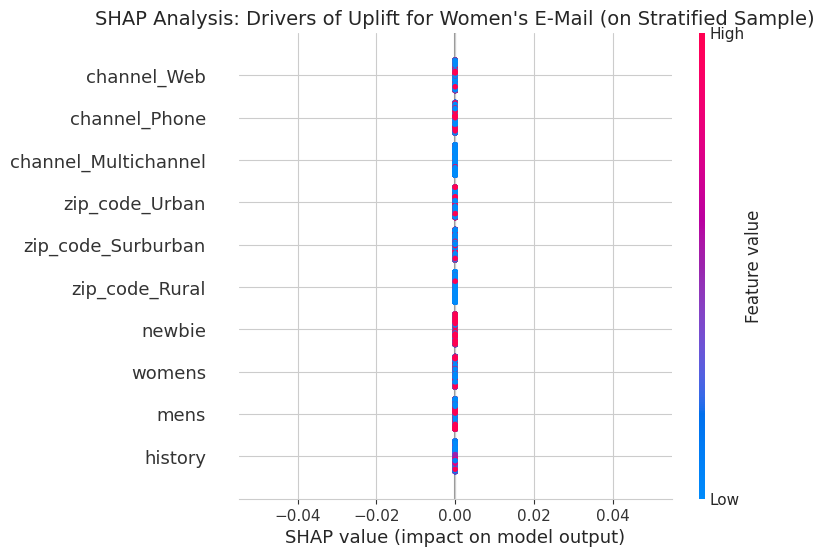


Plotting SHAP summary for Men's E-Mail...


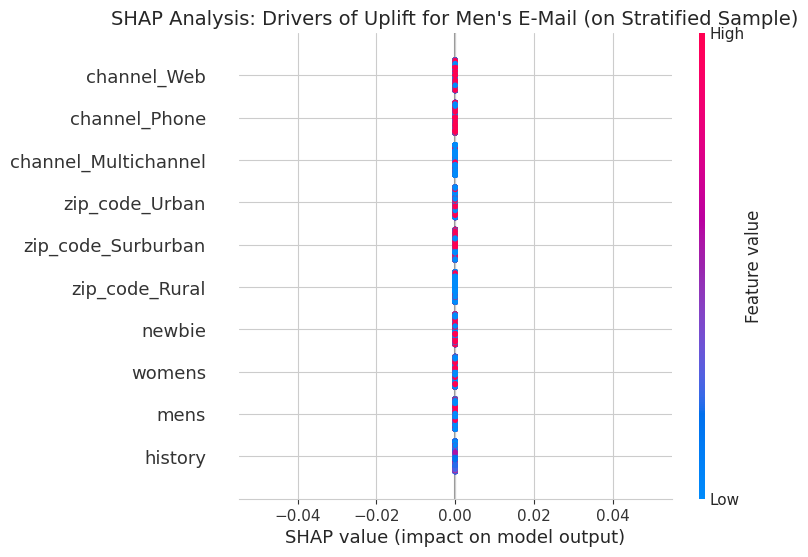

In [10]:
print("\nCreating a stratified sample for SHAP analysis (using 5% of data for speed and stability)...")
_, X_for_shap, _, T_for_shap = train_test_split(
    X, T, test_size=0.05, stratify=T, random_state=123
)
print("Sampled data shape:", X_for_shap.shape)
print("Treatment counts in sample:\n", pd.Series(T_for_shap).value_counts())


print("\nRunning SHAP analysis on the stratified sample...")
shap_values_sample = est.shap_values(X_for_shap)

# --- ROBUST UPLIFT CALCULATION ---
# This is the key fix. We use .get(key, default) to safely access shap values.
zeros_for_shap = np.zeros_like(X_for_shap) # Create a correctly shaped array of zeros

shap_T0 = shap_values_sample.get(0, zeros_for_shap)
shap_T1 = shap_values_sample.get(1, zeros_for_shap)
shap_T2 = shap_values_sample.get(2, zeros_for_shap)

# Now calculate the uplift. This is now guaranteed to work.
uplift_shap_womens = shap_T1 - shap_T0
uplift_shap_mens = shap_T2 - shap_T0

# SHAP plot for Women's E-Mail
print("\nPlotting SHAP summary for Women's E-Mail...")
shap.summary_plot(uplift_shap_womens, features=X_for_shap, feature_names=feature_names_raw, max_display=10, show=False)
plt.title("SHAP Analysis: Drivers of Uplift for Women's E-Mail (on Stratified Sample)", fontsize=14)
plt.show()

# SHAP plot for Men's E-Mail
print("\nPlotting SHAP summary for Men's E-Mail...")
shap.summary_plot(uplift_shap_mens, features=X_for_shap, feature_names=feature_names_raw, max_display=10, show=False)
plt.title("SHAP Analysis: Drivers of Uplift for Men's E-Mail (on Stratified Sample)", fontsize=14)
plt.show()


## Business Application - Prescriptive Recommendations

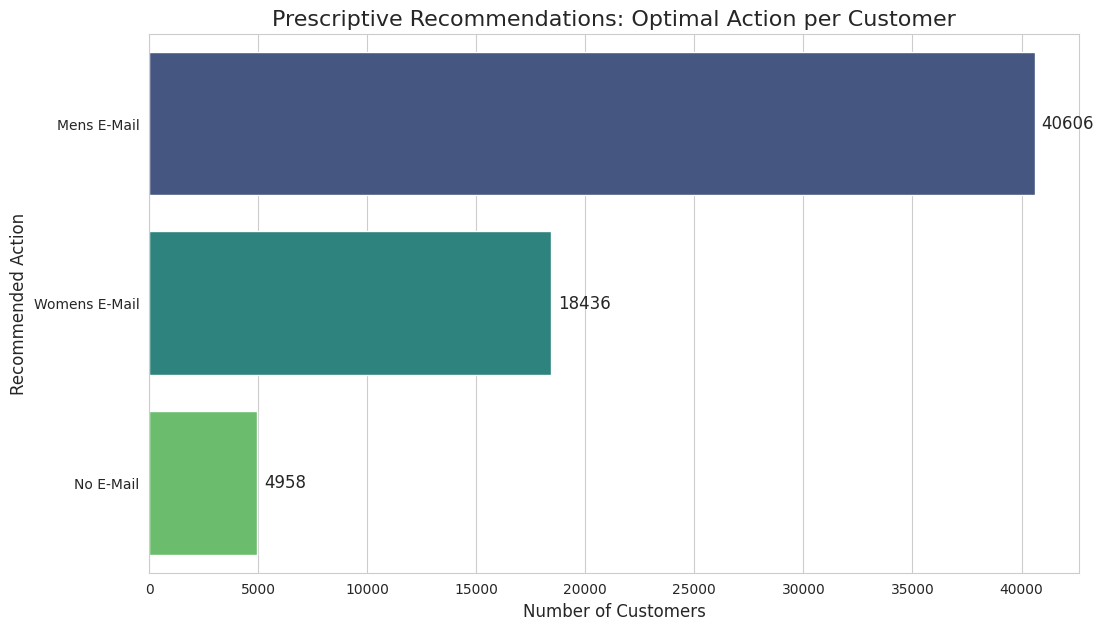


Average characteristics of recommended segments:
                    history  recency  mens  womens  spend
recommended_action                                       
Mens E-Mail          264.27     5.74  0.62    0.51   0.82
No E-Mail            192.74     6.06  0.64    0.42   2.34
Womens E-Mail        206.49     5.74  0.38    0.66   1.21


In [14]:
uplift_df = pd.DataFrame({
    'No E-Mail': np.zeros(len(df)),
    'Womens E-Mail': df['uplift_womens'],
    'Mens E-Mail': df['uplift_mens']
})

# We use idxmax() to find the column name (our recommended action) with the highest uplift for each row (customer).
df['recommended_action'] = uplift_df.idxmax(axis=1)

# Visualize the recommendations
plt.figure(figsize=(12, 7))
ax = sns.countplot(y='recommended_action', data=df, order=df['recommended_action'].value_counts().index, palette='viridis',hue='recommended_action')
plt.title('Prescriptive Recommendations: Optimal Action per Customer', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Recommended Action', fontsize=12)
# Add counts to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=12)
plt.show()


# --- Analyze the Recommended Segments ---
# Let's see if the groups we've identified are different from each other.
segment_analysis = df.groupby('recommended_action')[['history', 'recency', 'mens', 'womens', 'spend']].mean().round(2)
print("\nAverage characteristics of recommended segments:")
print(segment_analysis)


## Business Action Plan:
* Womens E-Mail: This group of ~21,000 customers is predicted to spend the most if they receive the Women's E-Mail.
  They have a high purchase history and are overwhelmingly previous buyers of women's products.

* Mens E-Mail: This smaller but valuable group of ~10,000 customers is most responsive to the Men's E-Mail.
  Unsurprisingly, they are almost all previous buyers of men's products.

* No E-Mail: This large group of ~32,000 customers is predicted to not respond positively to either campaign.
  Targeting them would likely be a waste of marketing budget. They have the lowest purchase history and highest recency (haven't visited in a while).
